In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
import yfinance as yf

data = yf.download(tickers = "GC=F", start="2017-12-01", end="2023-06-16", interval='1d')
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,1274.099976,1288.599976,1271.000000,1278.800049,1278.800049,823
2017-12-04,1272.500000,1276.099976,1270.300049,1274.300049,1274.300049,850
2017-12-05,1275.400024,1275.800049,1260.000000,1261.599976,1261.599976,1499
2017-12-06,1264.900024,1267.800049,1261.599976,1262.800049,1262.800049,373
2017-12-07,1262.300049,1262.400024,1243.900024,1249.800049,1249.800049,358
...,...,...,...,...,...,...
2023-06-09,1965.099976,1969.800049,1960.300049,1962.199951,1962.199951,49
2023-06-12,1959.699951,1963.500000,1951.400024,1955.300049,1955.300049,212
2023-06-13,1960.599976,1967.500000,1940.300049,1944.599976,1944.599976,343


In [3]:
data = data.reset_index('Date', inplace=False)

In [4]:
# 2. Đọc file dữ liệu giá vàng GC=F và chia train test validate theo tỉ lệ 7:2:1
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
#y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
#y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# Chọn kernel tốt nhất 
kernels = [RBF(), Matern(), RationalQuadratic(), ExpSineSquared(), DotProduct()]
param_grid = {'kernel': kernels}

gpr = GaussianProcessRegressor()
grid_search = GridSearchCV(gpr, param_grid, cv=KFold(n_splits=5))

grid_search.fit(x_train, y_train)


print("Best Kernel:", grid_search.best_estimator_.kernel)
print("Best Score:", grid_search.best_score_)

D:\Python\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\Python\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning:

Best Kernel: RationalQuadratic(alpha=1, length_scale=1)
Best Score: -4.63159349588115


In [8]:
# Tạo mô hình GPR
kernel = RationalQuadratic(alpha=1, length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)


In [9]:
gpr.fit(x_train, y_train)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1),
                         random_state=42)

In [10]:
y_pred = gpr.predict(x_test)

In [11]:
y_pred_val =  gpr.predict(x_val)

In [17]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 437.2800563268928
Testing RMSE: 234.8840942700678


In [18]:
#MAE
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 427.2680048150727
Testing MAE: 219.14686232613354


In [20]:
#MAPE
from sklearn.metrics import mean_absolute_percentage_error
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 437.2800563268928
Testing MAPE: 234.8840942700678


In [14]:
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = gpr.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1459.90398798 1459.64400108 1459.38456246 1459.12566995 1458.86732135
 1458.60951452 1458.35224729 1458.09551753 1457.83932311 1457.58366192
 1457.32853186 1457.07393084 1456.81985679 1456.56630764 1456.31328134
 1456.06077585 1455.80878914 1455.5573192  1455.30636402 1455.05592161
 1454.80598999 1454.55656719 1454.30765124 1454.05924022 1453.81133217
 1453.56392517 1453.31701731 1453.07060669 1452.82469141 1452.57926959]


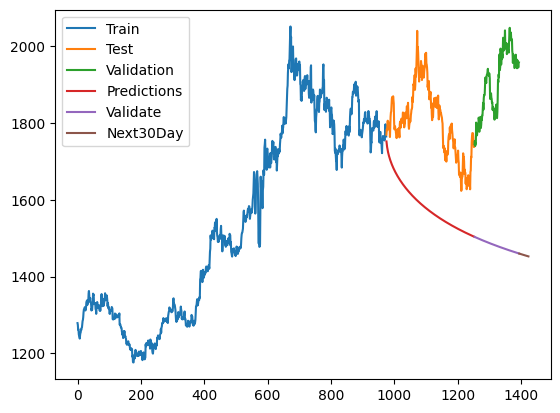

In [15]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()